Original noise parameters ($\sigma_\Omega, \sigma_\Delta, \sigma_\epsilon$) based on "Experimental Bayesian Calibration of Trapped-Ion Entangling Operations" (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350).

Derivative noise parameters ($\sigma_I, \sigma_{f_{cl}}, \sigma_{f_{sb}}$) based on **single_qubit_rotations/single_qubit_noise_sim.ipynb**.

In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  8.373134 seconds (14.88 M allocations: 957.627 MiB, 9.55% gc time, 99.86% compilation time: <1% of which was recompilation)


In [2]:
using QuantumOptics
import PyPlot
using Random, Distributions
using ProgressBars
Random.seed!(0)

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

The Molmer-Sorensen Hamiltonian: $\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

## 0. Setup

Global variables

In [256]:
######################### Optimal parameter values #########################
# See molmer_sorensen_scans_zoomed.ipynb for how these were determined
INTENSITY_MS = 94326.65907221894 # W/cm^2
TRAP_FREQUENCY = 2.5e5 # Hz
WAVELENGTH_CL_MS = 7.291469940286511e-7 # m
B_STRENGTH = 0.0005999899999999999; # T

######################### Parameter noise values #########################
# See molmer_sorensen_noise_sim.ipynb for how these were determined

# Intensity 
Ω_opt = 1e7
κ = INTENSITY_MS/(Ω_opt^2)
σ_Ω = 0.2Ω_opt
σ_I = κ*sqrt(2*(σ_Ω^4) + 4*(σ_Ω^2)*Ω_opt^2 )

# Center-line frequency
δλ_MAX = 1e-15
C0 = 2.99792458e8
FREQUENCY_CL_MS = C0/WAVELENGTH_CL_MS
σ_f_cl = 2e3

# Trap frequency
σΔ = 2e3
σ_ν = σΔ

######################### Other global variables #########################

N_SAMPLES = Int(1e4)
FINITE_RWA_CUTOFF = 1e20

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
ψ0_ELECTRONIC = CALCIUM40["S"] ⊗ CALCIUM40["S"] # |0> \otimes |0>
BELL_STATE = dm((CALCIUM40["S"] ⊗ CALCIUM40["S"] + 1im * CALCIUM40["D"] ⊗ CALCIUM40["D"])/√2); # (|00> + i|11>)/√2

TIMESCALE = 1e-6 # seconds 
DETUNING = 1e4 # Hz
GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
AC_CORRECTION = 0; # Hz
PI_TIME = 2e-6

# Intialize chamber object, whose properties will be updated in the loop
MS_CHAMBER_TUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

VIB_MODE = IonSim.modes(MS_CHAMBER_TUNED)[1] # first vibrational mode
ψ0_MOTIONAL = VIB_MODE[0] # GLOBAL: ground state of the first vibrational mode
ψ0 = ψ0_ELECTRONIC ⊗ ψ0_MOTIONAL; # GLOBAL: initial state for all the simulations

In [178]:
function plot_populations_double(chamber, tout, sol)
    vibrational_mode = IonSim.modes(chamber)[1]

    SS = ionprojector(chamber, "S", "S")
    DD = ionprojector(chamber, "D", "D")
    SD = ionprojector(chamber, "S", "D")
    DS = ionprojector(chamber, "D", "S")
    bell_state_projector = dm((Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["S"] ⊗ Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["S"] 
        + 1im * Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["D"] ⊗ Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])["D"])/√2) ⊗ one(vibrational_mode)

    # compute expectation values
    prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
    prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
    prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
    prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
    prob_bell = expect(bell_state_projector, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

    # plot results
    fig  = plt.figure()
    plt.plot(tout, prob_SS, label="SS")
    plt.plot(tout, prob_DD, label="DD")
    plt.plot(tout, prob_SD, label="SD")
    plt.plot(tout, prob_DS, label="DS")
    plt.plot(tout, prob_bell, label="Bell state")
    plt.xlim(tout[1], tout[end])
    plt.ylim(0, 1)
    plt.legend(loc=1)
    plt.xlabel("Time (μs)");
    plt.display(fig)
end

plot_populations_double (generic function with 1 method)

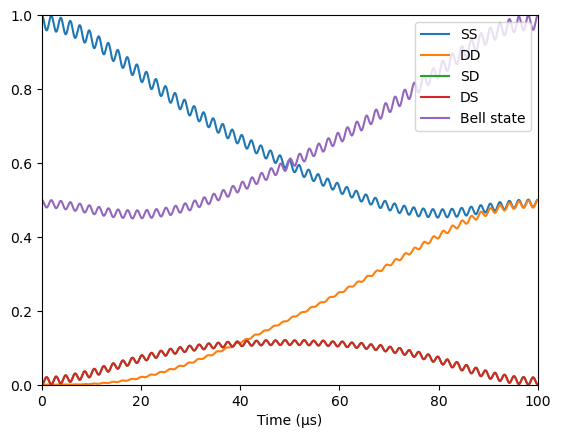

  0.118593 seconds (1.76 M allocations: 67.441 MiB)
Bell-state fidelity: 0.99956612010231
Electronic-Motional entanglement entropy: 0.005708204423706869


In [250]:
h = hamiltonian(MS_CHAMBER_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
@time tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
plot_populations_double(MS_CHAMBER_TUNED, tout, sol)

ρ_final = dm(sol[end])
ρ_final_electronic = ptrace(ρ_final, 3)
bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
ee = entropy_vn(ρ_final_electronic)
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", real(ee), "\n")

Functions to update true parameters, given measured parameters

### 1. Intensity
$\kappa = \frac{I}{\Omega^2} \Longrightarrow \Omega^2 = \frac{I}{\kappa} \Longrightarrow \Omega = \sqrt{\frac{I}{\kappa}}$

$\frac{\Omega_{\text{opt}}}{\overline{\Omega}} = \frac{\sqrt{I_{\text{opt}}/\kappa}}{\sqrt{\overline{I}/\kappa}} = \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}$

In the text, they update: $t_g \to t_g \frac{\Omega_{\text{opt}}}{\overline{\Omega}}$

Since $t_g \sim I$, here we will update: $\boxed{I \to I \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}}$

### 2. Center-line frequency

In the text, they update: $f_{\text{cl}} \to f_{\text{cl}} - (  \overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}} )$. 

**Mind the confusing notation**: here, $\omega_{\text{cl}}$ is not an angular frequency, they just use $\omega$ to denote the center-line *detuning* as opposed to the center-line frequency. With this in mind, it's clear that $\overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}}$ is exactly equivalent to $ \overline{f}_{\text{cl}} - f_{\text{cl, opt}}$. 

So we will update: $\boxed{f_{\text{cl}} \to f_{\text{cl}} - ( \overline{f}_{\text{cl}} - f_{\text{cl, opt}} )}$

### 3. Trap-frequency

In the text, they update: $f_{\text{sb}} \to f_{\text{sb}} - ( \overline{\delta} - \delta_{\text{opt}})$

So, once again, we simply update: $\boxed{\nu \to \nu - (\overline{\nu} - \nu_{\text{opt}})}$

In [152]:
# Intensity
function compute_I_new(chamber, I_bar)
    I = chamber.lasers[1].I(0)
    return I*sqrt(INTENSITY_MS/I_bar)
end

function update_intensity(chamber, I_new)
    intensity!(chamber.lasers[1], I_new)
    intensity!(chamber.lasers[2], I_new)
end

# Center-line frequency 
function compute_f_cl_new(chamber, f_cl_bar)
    λ_cl = chamber.lasers[1].λ
    f_cl = C0/λ_cl
    return f_cl - (f_cl_bar - FREQUENCY_CL_MS)
end

function update_f_cl(chamber, f_cl_new)
    wavelength!(chamber.lasers[1], C0/f_cl_new)
    wavelength!(chamber.lasers[2], C0/f_cl_new)
end

# Trap-frequency
function compute_ν_new(chamber, ν_bar)
    ν = chamber.iontrap.comfrequencies.z
    return ν - (ν_bar - TRAP_FREQUENCY)
end

function update_ν(chamber, ν_new)
    # Can't update the trap-frequency in-place
    # Must create a brand new chamber, with all the same properties except for the trap frequency
    I = chamber.lasers[1].I(0)
    λ_cl = chamber.lasers[1].λ
    chamber_new = construct_MS_chamber(
        ν_new,
        I,
        λ_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    # Recall: The detuning is based on the *target* trap-frequency
    chamber.lasers[1].Δ = TRAP_FREQUENCY + DETUNING - AC_CORRECTION
    chamber.lasers[2].Δ = -(TRAP_FREQUENCY + DETUNING - AC_CORRECTION)
    return chamber_new
end 
 

update_ν (generic function with 1 method)

Run the noise-sim to check our parameter-update functions

In [165]:
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
N_SAMPLES_TEST = Int(1e3)

Normal_I = Normal(INTENSITY_MS, σ_I)
Normal_f_cl = Normal(FREQUENCY_CL_MS, σ_f_cl)
Normal_ν  = Normal(TRAP_FREQUENCY, σ_ν)

fidelities = zeros(N_SAMPLES_TEST)
entanglement_entropies = zeros(N_SAMPLES_TEST)
|
for i in 1:N_SAMPLES_TEST
    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    I_new = rand(Normal_I)[1]
    if I_new<0
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    f_cl_new = rand(Normal_f_cl)[1]
    λ_cl_new = C0/f_cl_new
    δλ = abs(WAVELENGTH_CL_MS - λ_cl_new)
    if δλ > δλ_MAX
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    ν_new = rand(Normal_ν)[1]
    
    try
        # actual trap-frequency is ν
        update_intensity(MS_CHAMBER_UNTUNED, I_new)
        update_f_cl(MS_CHAMBER_UNTUNED, f_cl_new)
        MS_CHAMBER_UNTUNED = update_ν(MS_CHAMBER_UNTUNED, ν_new)

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h)
        ρ_final = dm(sol[end])
        ρ_final_electronic = ptrace(ρ_final, 3)
        fid_i = fidelity(ρ_final_electronic, BELL_STATE)
        S_i = entropy_vn(ρ_final_electronic)

        #@assert imag(fid) < 1e-8
        fidelities[i] = real(fid_i)
        entanglement_entropies[i] = S_i
    catch
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
    end
end


100
200
300
400
500
600
700
800
900
1000

In [166]:
fidelities = fidelities[.~isnan.(fidelities)]
print("\nlength(fidelities) = ", length(fidelities))

entanglement_entropies = entanglement_entropies[.~isnan.(entanglement_entropies)]
print("\nlength(entanglement_entropies) = ", length(entanglement_entropies))


length(fidelities) = 991
length(entanglement_entropies) = 991

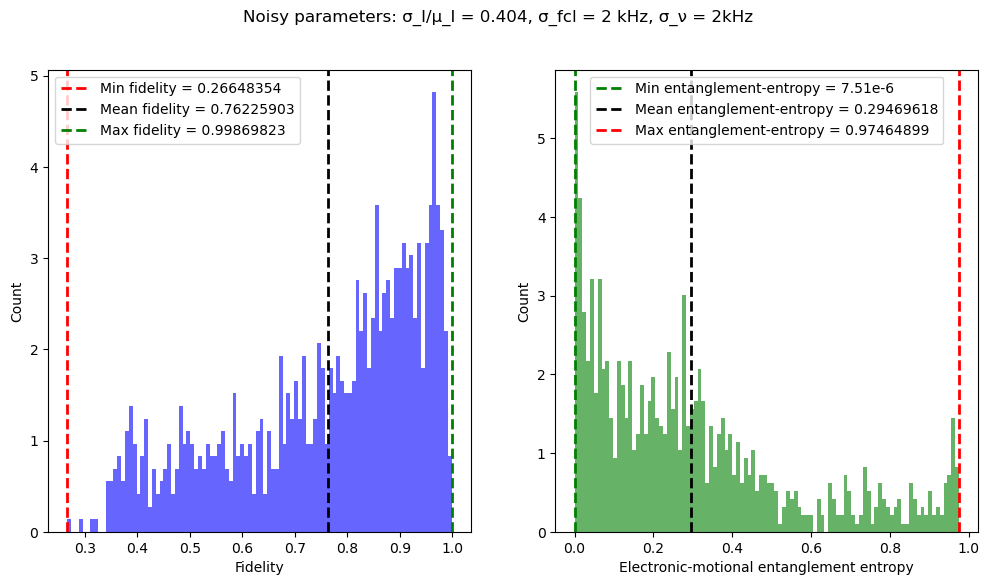

In [172]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.hist(fidelities, bins=100, density=true, alpha=0.6, color="b")
ax1.axvline(minimum(fidelities), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities); digits=8))")
ax1.axvline(mean(fidelities), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities); digits=8))")
ax1.axvline(maximum(fidelities), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities); digits=8))")
ax1.set_xlabel("Fidelity")
ax1.set_ylabel("Count")
ax1.legend()

ax2.hist(entanglement_entropies, bins=100, density=true, alpha=0.6, color="g")
ax2.axvline(minimum(entanglement_entropies), color="g", linestyle="--", linewidth=2, label="Min entanglement-entropy = $(round(minimum(entanglement_entropies); digits=8))")
ax2.axvline(mean(entanglement_entropies), color="k", linestyle="--", linewidth=2, label="Mean entanglement-entropy = $(round(mean(entanglement_entropies); digits=8))")
ax2.axvline(maximum(entanglement_entropies), color="r", linestyle="--", linewidth=2, label="Max entanglement-entropy = $(round(maximum(entanglement_entropies); digits=8))")
ax2.set_xlabel("Electronic-motional entanglement entropy")
ax2.set_ylabel("Count")
ax2.legend()

fig.suptitle("Noisy parameters: σ_I/μ_I = 0.404, σ_fcl = 2 kHz, σ_ν = 2kHz")
plt.display(fig)

# 1. Bayesian parameter update

$ P(\Theta|m) \propto P(m|\Theta) P(\Theta)$, up to some normalization


## 1.a. Compute the initial prior

"The Bayesian inference requires an initial prior (i.e. $P(\Theta)$), and we must choose an initial set of particles to represent this prior. We choose a known continuous probability density function as prior."

For us: $\Theta = (I, f_{\text{cl}}, \nu) \Longrightarrow P(\Theta) \sim \mathcal{N}(\mu_I, \sigma_I) \times \mathcal{N}(\mu_{f_{\text{cl}}}, \sigma_{f_{\text{cl}}})  \times \mathcal{N}(\mu_\nu, \sigma_\nu) $

$\Longrightarrow \boxed{P(\Theta) = \frac{1}{(2\pi)^{3/2} \sqrt{\sigma_I \sigma_{f_{\text{cl}}} \sigma_\nu }} \exp\left[-\frac{1}{2} \left( \frac{(i - \mu_I)^2}{\sigma_I^2} + \frac{(f - \mu_{f_{\text{cl}}})^2}{\sigma_{f_{\text{cl}}}^2} + \frac{(v - \mu_\nu)^2}{\sigma_\nu^2} \right)\right]} $

"We can then initialize the particle filter from that probability function by randomly sampling $N_p$ times from the distribution and setting all the weights to $1/N_p$."

In [174]:
N_p = Int(1e3)
particles_I = []
particles_f_cl = []
particles_ν = []
weights = []

n_collected = 0
while n_collected < N_p
    I_new = rand(Normal_I)[1]
    if I_new<0
        continue
    end

    f_cl_new = rand(Normal_f_cl)[1]
    λ_cl_new = C0/f_cl_new
    δλ = abs(WAVELENGTH_CL_MS - λ_cl_new)
    if δλ > δλ_MAX
        continue
    end

    ν_new = rand(Normal_ν)[1]

    append!(particles_I, I_new)
    append!(particles_f_cl, f_cl_new)
    append!(particles_ν, ν_new)
    append!(weights, 1.0)
    n_collected += 1
end

weights = weights ./ sum(weights);

## 1.b. Compute $P(m|\Theta)$

In order to do this we must first:

(i) Define our measurement $m$: **for now, 100 measurements of $\hat{Z}$ and 100 measurements of $\hat{X}$**


(ii) Be able to conduct our measurement $m$

λ_single = 7.291469960190796e-7
I_single = 1649.5037887235235


┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:98


In [349]:
function construct_two_qubit_chamber(
    I_MS,
    λ_MS,

    # Ion-chain parameters
    trap_frequency,

    # Trap parameters
    B_strength;

    detuning = DETUNING,
    ac_correction = AC_CORRECTION,
    pi_time = PI_TIME
    )

    chain = LinearChain(
        ions = [CALCIUM40, CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = trap_frequency), 
        selectedmodes = (;z = [1],)
    )

    # Single-qubit lasers
    laser1 = Laser(pointing=[(1, 1.), (2, 0.)], Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = 0)
    laser2 = Laser(pointing=[(1, 0.), (2, 1.)], Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = 0)

    # MS Lasers
    d = ac_correction
    Δ_red = -(trap_frequency + detuning - d )
    Δ_blue = trap_frequency + detuning - d 
    laser_red_sideband = Laser(pointing=[(1, 1.), (2, 1.)], I = I_MS, λ = λ_MS, Δ=Δ_red, ϵ = x̂, k = ẑ) 
    laser_blue_sideband = Laser(pointing=[(1, 1.), (2, 1.)], I = I_MS, λ = λ_MS, Δ=Δ_blue, ϵ = x̂, k = ẑ) 

    # Chamber    
    chamber = Chamber(iontrap=chain, B=B_strength, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2, laser_red_sideband, laser_blue_sideband]);
    
    # For now, the single-qubit lasers are calibrated from the start. Don't want to get too complicated.
    λ_single = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
    print("λ_single = ", λ_single, "\n")
    wavelength!(laser1, λ_single)
    wavelength!(laser2, λ_single)
    
    I_single = intensity_from_pitime(laser1, pi_time, CALCIUM40, ("S", "D"), chamber)
    print("I_single = ", I_single, "\n")
    intensity!(laser1, I_single)
    intensity!(laser2, I_single)

    return chamber
end

chamber_test = construct_two_qubit_chamber(INTENSITY_MS, WAVELENGTH_CL_MS, TRAP_FREQUENCY, B_STRENGTH, pi_time=PI_TIME);

λ_single = 7.29146994028719e-7
I_single = Inf


┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:98


Test MS gate

In [334]:
chamber_test.lasers[4].I(0)

94326.65907221894

In [356]:
function construct_two_qubit_chamber(
    I_MS,
    λ_MS,

    # Ion-chain parameters
    trap_frequency,

    # Trap parameters
    B_strength;

    detuning = DETUNING,
    ac_correction = AC_CORRECTION,
    pi_time = PI_TIME
    )

    chain = LinearChain(
        ions = [CALCIUM40, CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = trap_frequency), 
        selectedmodes = (;z = [1],)
    )

    # Single-qubit lasers
    laser1 = Laser(pointing=[(1, 1.), (2, 0.)], Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = 0)
    laser2 = Laser(pointing=[(1, 0.), (2, 1.)], Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = 0)

    # MS Lasers
    d = ac_correction
    Δ_red = -(trap_frequency + detuning - d )
    Δ_blue = trap_frequency + detuning - d 
    laser_red_sideband = Laser(pointing=[(1, 1.), (2, 1.)], I = I_MS, λ = λ_MS, Δ=Δ_red, ϵ = x̂, k = ẑ) 
    laser_blue_sideband = Laser(pointing=[(1, 1.), (2, 1.)], I = I_MS, λ = λ_MS, Δ=Δ_blue, ϵ = x̂, k = ẑ) 

    # Chamber    
    chamber = Chamber(iontrap=chain, B=B_strength, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2, laser_red_sideband, laser_blue_sideband]);
    
    # For now, the single-qubit lasers are calibrated from the start. Don't want to get too complicated.
    λ_single = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
    print("λ_single = ", λ_single, "\n")
    wavelength!(laser1, λ_single)
    wavelength!(laser2, λ_single)


    # In order to compute these, we must turn off the MS lasers (and the other single-qubit laser), momentarily.
    # This is fine because, when we're actually performing a single-qubit gate, we'll turn off the MS lasers (and the other single-qubit laser) anyway.
    # intensity!(laser_red_sideband, 0)
    # intensity!(laser_blue_sideband, 0)
    #intensity!(laser2, 0)
    
    
    # I_single = intensity_from_pitime(1, pi_time, 1, ("S", "D"), chamber)
    # I_single = 1649.5037887235235
    # print("I_single = ", I_single, "\n")
    # intensity!(laser1, I_single)
    # intensity!(laser2, I_single)

    # intensity!(laser_red_sideband, I_MS)
    # intensity!(laser_blue_sideband, I_MS)

    return chamber
end

chamber_test = construct_two_qubit_chamber(INTENSITY_MS, WAVELENGTH_CL_MS, 1e6, 4e-4, pi_time=GATE_TIME);

λ_single = 7.291469960190796e-7


┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:98


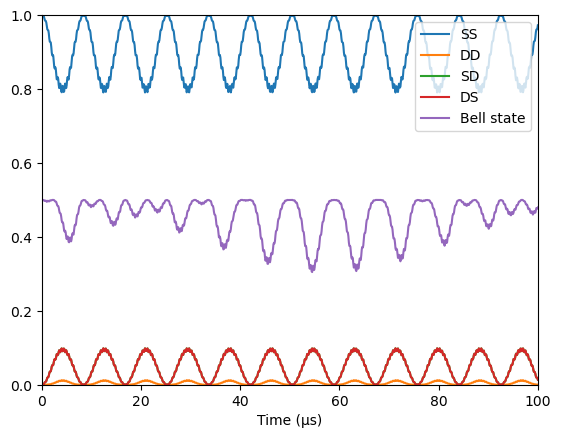

  0.373831 seconds (6.52 M allocations: 247.531 MiB, 7.91% gc time, 3.35% compilation time)
Bell-state fidelity: 0.6925069695483275
Electronic-Motional entanglement entropy: -1.0565311736209234e-5


In [357]:
function do_MS(chamber, gate_time)
    I_single = chamber.lasers[1].I

    # Turn off the single-qubit lasers
    intensity!(chamber.lasers[1], 0)
    chamber.lasers[1].pointing = [(1, 0.), (2, 0.)]
    intensity!(chamber.lasers[2], 0)
    chamber.lasers[2].pointing = [(1, 0.), (2, 0.)]

    # We don't really need a wavelength for the single-qubit lasers, but just set it here to avoid errors
    # wavelength!(chamber.lasers[1], WAVELENGTH_CL_MS)
    # wavelength!(chamber.lasers[2], WAVELENGTH_CL_MS)

    # Evolve for an MS gate
    h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h)

    # Turn the single-qubit lasers back on
    intensity!(chamber.lasers[1], I_single)
    intensity!(chamber.lasers[2], I_single)

    return tout, sol
end

@time tout, sol = do_MS(chamber_test, GATE_TIME);
plot_populations_double(chamber_test, tout, sol)

ρ_final = dm(sol[end])
ρ_final_electronic = ptrace(ρ_final, 3)
bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
ee = entropy_vn(ρ_final_electronic)
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", real(ee), "\n")

Test RX on either qubit

In [283]:
function do_RX(chamber, ion_idx, gate_time)
    I_sideband = chamber.lasers[3].I

    # Turn off the sideband lasers
    intensity!(chamber.lasers[3], 0)
    intensity!(chamber.lasers[4], 0)

    # Turn off the other single-qubit laser
    # I_single = chamber.lasers[1].I
    # if ion_idx == 1
    #     intensity!(chamber.lasers[2], 0)
    # else
    #     intensity!(chamber.lasers[1], 0)
    # end

    # Evolve for an RX gate
    h = hamiltonian(chamber, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h)

    # Turn the sideband lasers back on
    intensity!(chamber.lasers[3], I_sideband)
    intensity!(chamber.lasers[4], I_sideband)

    # Turn the other single-qubit laser back on
    # if ion_idx == 1
    #     intensity!(chamber.lasers[2], I_single)
    # else
    #     intensity!(chamber.lasers[1], I_single)
    # end

    return tout, sol
end

@time tout, sol = do_RX(chamber_test, 1, PI_TIME);

# ρ_final = dm(sol[end])
# ρ_final_electronic = ptrace(ρ_final, 3)
# bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
# ee = entropy_vn(ρ_final_electronic)
# print("Bell-state fidelity: ", real(bs_fid), "\n")
# print("Electronic-Motional entanglement entropy: ", real(ee), "\n")

  0.010159 seconds (21.10 k allocations: 1.142 MiB, 77.34% compilation time)


┌ Warning: First function call produced NaNs. Exiting. Double check that none of the initial conditions, parameters, or timespan values are NaN.
└ @ OrdinaryDiffEq /home/aelabd/.julia/packages/OrdinaryDiffEq/Knuk0/src/initdt.jl:131
┌ Warning: At t=0.0, dt was forced below floating point epsilon 5.0e-324, and step error estimate = 1.0. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of ComplexF64).
└ @ SciMLBase /home/aelabd/.julia/packages/SciMLBase/sakPO/src/integrator_interface.jl:633


(Float64[], Ket{CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, IonInstance{:Ca40}, VibrationalMode}}, Vector{ComplexF64}}[])

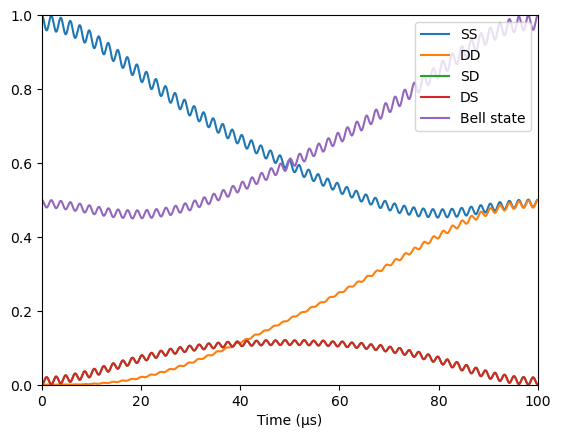

  0.122234 seconds (1.76 M allocations: 67.441 MiB, 8.00% gc time)
Bell-state fidelity: 0.99956612010231
Electronic-Motional entanglement entropy: 0.005708204423706869


In [201]:
h = hamiltonian(MS_CHAMBER_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
@time tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ψ0, h);
plot_populations_double(MS_CHAMBER_TUNED, tout, sol)

ρ_final = dm(sol[end])
ρ_final_electronic = ptrace(ρ_final, 3)
bs_fid = fidelity(ρ_final_electronic, BELL_STATE)
ee = entropy_vn(ρ_final_electronic)
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", real(ee), "\n")